In [ ]:
# NN tryouts on SPR data, inspired by Kaggle Forum "When less is more"

Load training and validation data as 
    month : [ Features | Targets| Difference | Last Choice Targets  ]
    
    - Features : 
    - Target labels : TARGET_LABELS(month), 'targets_str', 'targets_features'
    - Difference with prev month
    - Last Choice Targets : LC_TARGET_LABELS(month-1), 'lc_targets_str', 'lc_targets_features'


In [1]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.INFO)

import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [24]:
from dataset import load_trainval, LC_TARGET_LABELS, decimal_to_dummies, targets_str_to_indices, targets_dec_to_indices
from common import to_yearmonth, TARGET_LABELS 
from common import target_str_to_labels, TARGET_LABELS2

In [4]:
features = [
    u'ind_empleado', u'pais_residencia',
    u'sexo', u'age', u'ind_nuevo', u'antiguedad', u'indrel',
    u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
    u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
    u'ind_actividad_cliente', u'renta', u'segmento'    
]

In [6]:
train_yearmonths_list = [201503, 201504, 201505, 201506, 201603, 201604]
#train_yearmonths_list = [201505, 201506, 201604]
val_yearmonth = [201505]
train_nb_clients = 150000
train_df, val_df = load_trainval(train_yearmonths_list, val_yearmonth, train_nb_clients)

INFO:root:- Load training data : [201502, 201503, 201504, 201505, 201506, 201602, 201603, 201604]
INFO:root:-- Select 150000 clients
INFO:root:- Number of lines with unknown data : 45
INFO:root:- Number of columns with nan : 9
INFO:root:-- Process date : 201503
INFO:root:-- Process date : 201504
INFO:root:-- Process date : 201505
INFO:root:-- Process date : 201506
INFO:root:-- Process date : 201603
INFO:root:-- Process date : 201604
INFO:root:- Load validation : [201604, 201605]
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Process date : 201605


Display loaded data

In [7]:
print train_df.shape, train_df.columns

(1199928, 73) Index([u'fecha_dato', u'ncodpers', u'ind_empleado', u'pais_residencia',
       u'sexo', u'age', u'fecha_alta', u'ind_nuevo', u'antiguedad', u'indrel',
       u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
       u'ind_actividad_cliente', u'renta', u'segmento', u'ind_ahor_fin_ult1',
       u'ind_aval_fin_ult1', u'ind_cco_fin_ult1', u'ind_cder_fin_ult1',
       u'ind_cno_fin_ult1', u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1',
       u'ind_ctop_fin_ult1', u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1',
       u'ind_deme_fin_ult1', u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1',
       u'ind_fond_fin_ult1', u'ind_hip_fin_ult1', u'ind_plan_fin_ult1',
       u'ind_pres_fin_ult1', u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1',
       u'ind_valo_fin_ult1', u'ind_viv_fin_ult1', u'ind_nomina_ult1',
       u'ind_nom_pens_ult1', u'ind_recibo_ult1', u'targets_str',
       u'lc_ind_ahor_fin_ult1', u'lc_ind_ava

In [8]:
print val_df.shape, val_df.columns

(1853326, 73) Index([u'fecha_dato', u'ncodpers', u'ind_empleado', u'pais_residencia',
       u'sexo', u'age', u'fecha_alta', u'ind_nuevo', u'antiguedad', u'indrel',
       u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
       u'ind_actividad_cliente', u'renta', u'segmento', u'ind_ahor_fin_ult1',
       u'ind_aval_fin_ult1', u'ind_cco_fin_ult1', u'ind_cder_fin_ult1',
       u'ind_cno_fin_ult1', u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1',
       u'ind_ctop_fin_ult1', u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1',
       u'ind_deme_fin_ult1', u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1',
       u'ind_fond_fin_ult1', u'ind_hip_fin_ult1', u'ind_plan_fin_ult1',
       u'ind_pres_fin_ult1', u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1',
       u'ind_valo_fin_ult1', u'ind_viv_fin_ult1', u'ind_nomina_ult1',
       u'ind_nom_pens_ult1', u'ind_recibo_ult1', u'targets_str',
       u'lc_ind_ahor_fin_ult1', u'lc_ind_ava

In [9]:
#train_df.head(10)

Useful structures

In [10]:
def get_common_clients(df1, mask1, mask2, df2=None):
    active_clients1 = df1[mask1]['ncodpers'].unique()
    if df2 is not None:
        active_clients2 = df2[mask2]['ncodpers'].unique()
    else:
        active_clients2 = df1[mask2]['ncodpers'].unique()
    active_clients = list(set(active_clients1) & set(active_clients2)) 
    
    if df2 is not None:
        return df1['ncodpers'].isin(active_clients), df2['ncodpers'].isin(active_clients)
    return df1['ncodpers'].isin(active_clients)

In [11]:
months_ym_map = {}
months = list(set(train_df['fecha_dato'].unique()) | set(val_df['fecha_dato'].unique()))
for m in months:
    months_ym_map[to_yearmonth(m)] = m
    
train_months = train_df['fecha_dato'].unique()
val_months = val_df['fecha_dato'].unique()

## Insert 'targets_logCount' data

- insert current month target log count
- insert all data target log count
- insert diff between all data log counts


In [31]:
train_targets_str = train_df['targets_str'].unique()
val_targets_str = val_df['targets_str'].unique()
common_targets_str = list(set(train_targets_str) & set(val_targets_str))
diff_targets_str = list(set(train_targets_str) ^ set(val_targets_str))
print len(train_targets_str), len(val_targets_str), len(common_targets_str), len(diff_targets_str)

5526 7261 4468 3851


In [34]:
#target_str_to_labels(common_targets_str[:10], TARGET_LABELS2)

[array(['Current Accounts', 'e-account', 'Funds', 'Pensions (plan fin)',
        'Taxes', 'Securities', 'Payroll', 'Pensions', 'Direct Debit'], 
       dtype='|S23'),
 array(['Current Accounts', 'Mas particular Account', 'e-account',
        'Mortgage', 'Credit Card', 'Direct Debit'], 
       dtype='|S23'),
 array(['Payroll Account', 'Taxes', 'Credit Card', 'Home Account',
        'Direct Debit'], 
       dtype='|S23'),
 array(['e-account', 'Taxes', 'Home Account', 'Direct Debit'], 
       dtype='|S23'),
 array(['e-account', 'Taxes', 'Home Account'], 
       dtype='|S23'),
 array(['Current Accounts', 'particular Plus Account',
        'Pensions (plan fin)', 'Loans', 'Credit Card', 'Direct Debit'], 
       dtype='|S23'),
 array(['Current Accounts', 'particular Plus Account',
        'Pensions (plan fin)', 'Loans', 'Credit Card'], 
       dtype='|S23'),
 array(['Payroll Account', 'e-account', 'Pensions (plan fin)', 'Taxes',
        'Payroll', 'Pensions'], 
       dtype='|S23'),
 array(['

In [79]:
train_targets_str = train_df['targets_str'].unique()
val_targets_str = val_df['targets_str'].unique()

TRAIN_LOGCOUNT_DICT = train_df['targets_str'].value_counts().apply(lambda x: np.log(x+1))
TRAIN_LOGCOUNT_DICT /= TRAIN_LOGCOUNT_DICT.sum()
VAL_LOGCOUNT_DICT = val_df['targets_str'].value_counts().apply(lambda x: np.log(x+1))
VAL_LOGCOUNT_DICT /= VAL_LOGCOUNT_DICT.sum()

targets_str_to_val = list(set(train_targets_str) - set(val_targets_str))
targets_str_to_train = list(set(val_targets_str) - set(train_targets_str))

TRAIN_LOGCOUNT_DICT = pd.concat([TRAIN_LOGCOUNT_DICT, pd.Series(np.zeros((len(targets_str_to_train))), index=targets_str_to_train)])
VAL_LOGCOUNT_DICT = pd.concat([VAL_LOGCOUNT_DICT, pd.Series(np.zeros((len(targets_str_to_val))), index=targets_str_to_val)])

LOGCOUNT_DICT = (TRAIN_LOGCOUNT_DICT + VAL_LOGCOUNT_DICT).sort_values(ascending=False)
LOGCOUNT_DICT /= LOGCOUNT_DICT.sum()

In [87]:
#print LOGCOUNT_DICT.shape, LOGCOUNT_DICT.min(), LOGCOUNT_DICT.max()
#print LOGCOUNT_DICT[:10]

In [86]:
def add_logcount(df, months, logcount_dict):    
    for m in months:
        logging.info("- Process month : %s" % m)
        tmask = df['fecha_dato'] == m
        current_logcount_dict = df[tmask]['targets_str'].value_counts().apply(lambda x: np.log(x+1))
        current_logcount_dict /= current_logcount_dict.sum()

        df.loc[tmask, 'targets_logcount1'] = df[tmask]['targets_str'].apply(lambda x: current_logcount_dict[x])
        df.loc[tmask, 'targets_logcount2'] = df[tmask]['targets_str'].apply(lambda x: logcount_dict[x])

        if df[tmask]['lc_targets_str'].isnull().sum() == 0:
            df.loc[tmask, 'lc_targets_logcount2'] = df[tmask]['lc_targets_str'].apply(lambda x: logcount_dict[x])
            df.loc[tmask, 'targets_logcount2_diff'] = df.loc[tmask, 'targets_logcount2'] - df.loc[tmask, 'lc_targets_logcount2']

    df.loc[df['targets_logcount2_diff'].isnull(),'targets_logcount2_diff'] = -99999
    df.loc[df['lc_targets_logcount2'].isnull(),'lc_targets_logcount2'] = -99999

    
add_logcount(train_df, train_months, LOGCOUNT_DICT)
add_logcount(val_df, val_months, LOGCOUNT_DICT)

INFO:root:- Process month : 2015-02-28
INFO:root:- Process month : 2015-03-28
INFO:root:- Process month : 2015-04-28
INFO:root:- Process month : 2015-05-28
INFO:root:- Process month : 2015-06-28
INFO:root:- Process month : 2016-02-28
INFO:root:- Process month : 2016-03-28
INFO:root:- Process month : 2016-04-28
INFO:root:- Process month : 2016-04-28
INFO:root:- Process month : 2016-05-28


In [127]:
#train_df.sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_logcount1', 'targets_logcount2', 'targets_logcount2_diff']].head(16)

,fecha_dato,ncodpers,targets_str,targets_logcount1,targets_logcount2,targets_logcount2_diff
210788,2015-02-28,15916,000010001000100101110001,0.000293,0.000318,-99999.000000
1048525,2015-03-28,15916,000010001000100101110001,0.000297,0.000318,0.000000
1466731,2015-04-28,15916,000010001000100101110001,0.000291,0.000318,0.000000
2308280,2015-05-28,15916,000010001000100101110001,0.000298,0.000318,0.000000
2940284,2015-06-28,15916,000010001000100101110001,0.000292,0.000318,0.000000
3635545,2016-02-28,15916,000000001000100101110001,0.000291,0.000106,-99999.000000
4380284,2016-03-28,15916,000010001000100101110001,0.000295,0.000318,0.000212
5430498,2016-04-28,15916,000010001000100101110001,0.000295,0.000318,0.000000
210784,2015-02-28,15920,001010010000000001000001,0.000759,0.000560,-99999.000000
1048521,2015-03-28,15920,001010010000000001000001,0.000689,0.000560,0.000000


In [91]:
#target_str_to_labels(VAL_LOGCOUNT_DICT[:15].index.values, TARGET_LABELS2)

[array(['Current Accounts'], 
       dtype='|S23'), array([], 
       dtype='|S23'), array(['Current Accounts', 'particular Account'], 
       dtype='|S23'), array(['Current Accounts', 'Direct Debit'], 
       dtype='|S23'), array(['particular Account'], 
       dtype='|S23'), array(['Current Accounts', 'e-account'], 
       dtype='|S23'), array(['e-account'], 
       dtype='|S23'), array(['Junior Account'], 
       dtype='|S23'), array(['Payroll Account', 'Payroll', 'Pensions', 'Direct Debit'], 
       dtype='|S23'), array(['Current Accounts', 'particular Plus Account'], 
       dtype='|S23'), array(['Current Accounts', 'Long-term deposits'], 
       dtype='|S23'), array(['Payroll Account'], 
       dtype='|S23'), array(['particular Plus Account'], 
       dtype='|S23'), array(['Payroll Account', 'Payroll', 'Pensions'], 
       dtype='|S23'), array(['Taxes'], 
       dtype='|S23')]

In [90]:
#target_str_to_labels(TRAIN_LOGCOUNT_DICT[:15].index.values, TARGET_LABELS2)

[array(['Current Accounts'], 
       dtype='|S23'), array(['Current Accounts', 'particular Account'], 
       dtype='|S23'), array(['particular Account'], 
       dtype='|S23'), array(['Current Accounts', 'Direct Debit'], 
       dtype='|S23'), array([], 
       dtype='|S23'), array(['Current Accounts', 'e-account'], 
       dtype='|S23'), array(['Junior Account'], 
       dtype='|S23'), array(['Current Accounts', 'particular Plus Account'], 
       dtype='|S23'), array(['e-account'], 
       dtype='|S23'), array(['Current Accounts', 'Long-term deposits'], 
       dtype='|S23'), array(['particular Plus Account'], 
       dtype='|S23'), array(['Payroll Account', 'Payroll', 'Pensions', 'Direct Debit'], 
       dtype='|S23'), array(['Payroll Account'], 
       dtype='|S23'), array(['Taxes'], 
       dtype='|S23'), array(['Current Accounts', 'e-account', 'Direct Debit'], 
       dtype='|S23')]

In [88]:
#target_str_to_labels(TRAIN_LOGCOUNT_DICT[:15].index.values, TARGET_LABELS2)

[array(['Current Accounts'], 
       dtype='|S23'), array(['Current Accounts', 'particular Account'], 
       dtype='|S23'), array(['particular Account'], 
       dtype='|S23'), array(['Current Accounts', 'Direct Debit'], 
       dtype='|S23'), array([], 
       dtype='|S23'), array(['Current Accounts', 'e-account'], 
       dtype='|S23'), array(['Junior Account'], 
       dtype='|S23'), array(['Current Accounts', 'particular Plus Account'], 
       dtype='|S23'), array(['e-account'], 
       dtype='|S23'), array(['Current Accounts', 'Long-term deposits'], 
       dtype='|S23'), array(['particular Plus Account'], 
       dtype='|S23'), array(['Payroll Account', 'Payroll', 'Pensions', 'Direct Debit'], 
       dtype='|S23'), array(['Current Accounts', 'particular Account', 'Long-term deposits'], 
       dtype='|S23'), array(['Current Accounts', 'e-account', 'Direct Debit'], 
       dtype='|S23'), array(['Current Accounts', 'Taxes'], 
       dtype='|S23'), array(['Taxes'], 
       dtype='

In [112]:
#target_str_to_labels(['001010001000110101110001'], TARGET_LABELS2)

In [88]:
mask = (~train_df['targets_logcount2_diff'].isin([0, -99999]))
train_df[mask].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_logcount1', 'targets_logcount2', 'targets_logcount2_diff']].head(20)

,fecha_dato,ncodpers,targets_str,targets_logcount1,targets_logcount2,targets_logcount2_diff
1048501,2015-03-28,15893,000000000000000000010000,0.001215,0.000589,0.000330
2940273,2015-06-28,15901,001000001000100000110001,0.000355,0.000271,0.000060
1048492,2015-03-28,15906,000010011001001000100001,0.000155,0.000046,0.000017
4380292,2016-03-28,15906,000010011001000000000011,0.000154,0.000097,0.000068
1048507,2015-03-28,15911,000010000001100000110001,0.000435,0.000271,0.000116
1466728,2015-04-28,15911,000010000011100000110001,0.000151,0.000058,-0.000213
1466741,2015-04-28,15923,000010000000100000100111,0.001282,0.000621,-0.000042
1048516,2015-03-28,15925,001000010000000000000000,0.002054,0.000887,0.000207
1466740,2015-04-28,15925,001000010000000000100000,0.001207,0.000589,-0.000298
2940302,2015-06-28,15925,001000010000000000100001,0.001087,0.000542,-0.000047


In [89]:
mask = (~val_df['targets_logcount2_diff'].isin([0, -99999]))
val_df[mask].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_logcount1', 'targets_logcount2', 'targets_logcount2_diff']].head(20)

,fecha_dato,ncodpers,targets_str,targets_logcount1,targets_logcount2,targets_logcount2_diff
1238761,2016-05-28,15889,001000001000000000110000,0.000268,0.000267,-0.000238
1238751,2016-05-28,15900,000000010000000001000001,0.000323,0.000324,-0.000127
1238787,2016-05-28,15925,001000010000000000100000,0.000685,0.000589,0.000047
1238786,2016-05-28,15926,001000010000010000010000,0.000594,0.000512,0.000132
1238785,2016-05-28,15927,000000001000000100000001,0.000070,0.000071,-0.000192
1238783,2016-05-28,15929,001000001000100000110001,0.000299,0.000271,0.000095
1238769,2016-05-28,15944,001000011000000001000001,0.000507,0.000450,0.000078
1238791,2016-05-28,15950,000000000000000101000001,0.000141,0.000147,-0.000201
1238734,2016-05-28,15952,001000000000000001000001,0.000800,0.000662,-0.000032
1238682,2016-05-28,15982,000000000000000000000000,0.001255,0.000917,0.000203


## Insert 'targets_logDecimal' data

- insert target log decimal value associated with binary target labels
- insert diff between decimals


In [114]:
from dataset import dummies_to_decimal

In [150]:
train_df.loc[:, 'targets_logDec'] = train_df[TARGET_LABELS].apply(dummies_to_decimal, axis=1)
mask = ~train_df['lc_targets_str'].isnull()
train_df.loc[mask, 'lc_targets_logDec'] = train_df[mask][LC_TARGET_LABELS].apply(dummies_to_decimal, axis=1)
train_df.loc[mask, 'targets_diff'] = train_df.loc[mask, 'targets_logDec'] - train_df.loc[mask, 'lc_targets_logDec']
train_df.loc[:, 'targets_logDec'] = train_df.loc[:, 'targets_logDec'].apply(lambda x: np.log(x+1))
train_df.loc[mask, 'lc_targets_logDec'] = train_df.loc[:, 'targets_logDec'].apply(lambda x: np.log(x+1))
mask = train_df['lc_targets_str'].isnull()
train_df.loc[mask, 'targets_diff'] = -99999
train_df.loc[mask, 'lc_targets_logDec'] = -99999

In [152]:
val_df.loc[:, 'targets_logDec'] = val_df[TARGET_LABELS].apply(dummies_to_decimal, axis=1)
mask = ~val_df['lc_targets_str'].isnull()
val_df.loc[mask, 'lc_targets_logDec'] = val_df[mask][LC_TARGET_LABELS].apply(dummies_to_decimal, axis=1)
val_df.loc[mask, 'targets_diff'] = val_df.loc[mask, 'targets_logDec'] - val_df.loc[mask, 'lc_targets_logDec']
val_df.loc[:, 'targets_logDec'] = val_df.loc[:, 'targets_logDec'].apply(lambda x: np.log(x+1))
val_df.loc[mask, 'lc_targets_logDec'] = val_df.loc[:, 'targets_logDec'].apply(lambda x: np.log(x+1))
mask = val_df['lc_targets_str'].isnull()
val_df.loc[mask, 'targets_diff'] = -99999
val_df.loc[mask, 'lc_targets_logDec'] = -99999

In [154]:
train_df.sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_logDec', 'lc_targets_logDec', 'targets_diff']].head(10)

,fecha_dato,ncodpers,targets_str,targets_logDec,lc_targets_logDec,targets_diff
210766,2015-02-28,15890,000010001000100100100111,13.234620,-99999.000000,-99999.0
1048503,2015-03-28,15890,000010001000100100100111,13.234620,2.655677,0.0
1466726,2015-04-28,15890,000010001000100100100111,13.234620,2.655677,0.0
2518926,2015-05-28,15890,000010001000100100100111,13.234620,2.655677,0.0
2940303,2015-06-28,15890,000010001000100100100111,13.234620,2.655677,0.0
3635526,2016-02-28,15890,000010001000100100100111,13.234620,-99999.000000,-99999.0
4380305,2016-03-28,15890,000010001000100100100111,13.234620,2.655677,0.0
5430449,2016-04-28,15890,000010001000100100100111,13.234620,2.655677,0.0
210764,2015-02-28,15893,000000000001000000010000,8.321908,-99999.000000,-99999.0
1048501,2015-03-28,15893,000000000000000000010000,2.833213,1.343703,-4096.0


In [ ]:
#val_df.sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_logDec', 'lc_targets_logDec', 'targets_logDec_diff']].head(10)

## Check active client performances 2015 -> 2016

1) We observed that client actions repeats from 2015 to 2016. For example, there are ~27% of clients that add the same products in 2015-MM and in 2016-MM and ~40% of clients that add or remove that same quantity of products in 2015-MM and 2016-MM.

In [157]:
yms = [201503, 201504, 201505]
#yms = [201505]

for ym in yms:
    ym1 = ym + 100
    
    df1 = train_df if months_ym_map[ym] in train_months else val_df
    df2 = train_df if months_ym_map[ym1] in train_months else val_df
    
    mask1 = (~df1['targets_logcount2_diff'].isin([0, -99999]))
    tmask1 = df1['fecha_dato'] == months_ym_map[ym]
    mask2 = (~df2['targets_logcount2_diff'].isin([0, -99999]))
    tmask2 = df2['fecha_dato'] == months_ym_map[ym1]
    
    active_clients_mask1, active_clients_mask2  = get_common_clients(df1, tmask1 & mask1, tmask2 & mask2, df2)
    
    mask1 &= active_clients_mask1
    t1 = df1[tmask1 & mask1].sort_values(['ncodpers'])['targets_logcount2_diff']

    mask2 &= active_clients_mask2
    t2 = df2[tmask2 & mask2].sort_values(['ncodpers'])['targets_logcount2_diff']

    print "-------"
    print ym, ym1
    total = t1.shape[0]
    eq = (t1.values == t2.values).sum()
    aeq = (np.abs(t1.values) == np.abs(t2.values)).sum()
    print "Percentage : eq =", eq*1.0/total, " | aeq =", aeq*1.0/total
    
       

-------
201503 201603
Percentage : eq = 0.265326633166  | aeq = 0.381574539363
-------
201504 201604
Percentage : eq = 0.303914835165  | aeq = 0.397321428571
-------
201505 201605
Percentage : eq = 0.279776674938  | aeq = 0.418734491315


In [158]:
yms = [201503, 201504, 201505]
#yms = [201505]

for ym in yms:
    ym1 = ym + 100
    
    df1 = train_df if months_ym_map[ym] in train_months else val_df
    df2 = train_df if months_ym_map[ym1] in train_months else val_df
    
    mask1 = (~df1['targets_diff'].isin([0, -99999]))
    tmask1 = df1['fecha_dato'] == months_ym_map[ym]
    mask2 = (~df2['targets_diff'].isin([0, -99999]))
    tmask2 = df2['fecha_dato'] == months_ym_map[ym1]
    
    active_clients_mask1, active_clients_mask2  = get_common_clients(df1, tmask1 & mask1, tmask2 & mask2, df2)
    
    mask1 &= active_clients_mask1
    t1 = df1[tmask1 & mask1].sort_values(['ncodpers'])['targets_diff']

    mask2 &= active_clients_mask2
    t2 = df2[tmask2 & mask2].sort_values(['ncodpers'])['targets_diff']

    print "-------"
    print ym, ym1
    total = t1.shape[0]
    eq = (t1.values == t2.values).sum()
    aeq = (np.abs(t1.values) == np.abs(t2.values)).sum()
    print "Percentage : eq =", eq*1.0/total, " | aeq =", aeq*1.0/total
    
       

-------
201503 201603
Percentage : eq = 0.343791722296  | aeq = 0.509012016021
-------
201504 201604
Percentage : eq = 0.405071967101  | aeq = 0.549006168609
-------
201505 201605
Percentage : eq = 0.378553770087  | aeq = 0.570766378245


In [159]:
mask1 = (~train_df['targets_logcount2_diff'].isin([0, -99999]))
tmask1 = train_df['fecha_dato'] == '2015-05-28'

mask2 = (~val_df['targets_logcount2_diff'].isin([0, -99999]))
tmask2 = val_df['fecha_dato'] == '2016-05-28'

active_clients_mask1, active_clients_mask2  = get_common_clients(train_df, tmask1 & mask1, tmask2 & mask2, val_df)

In [161]:
mask1 &= active_clients_mask1
t1 = train_df[tmask1 & mask1].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_logcount2_diff', 'targets_diff']]
t1.head(10)

,fecha_dato,ncodpers,targets_str,targets_logcount2_diff,targets_diff
2308355,2015-05-28,16357,000010000000100101100111,0.000083,6.0
2308391,2015-05-28,16515,001000010000000000100000,0.000047,-1.0
2307950,2015-05-28,16641,001010010000100001100001,-0.000083,-6.0
2308542,2015-05-28,18116,001000001000000000000000,0.000124,-1.0
2308509,2015-05-28,18139,000010011000100000000011,0.000019,-32.0
2308543,2015-05-28,18238,000010000000110001000001,-0.000059,-6.0
2308766,2015-05-28,18435,001000000000000000000000,0.000210,-1.0
2307034,2015-05-28,18769,001000000000000000000000,0.000210,-1.0
2306996,2015-05-28,19077,000010000000100100100111,0.000108,6.0
2307097,2015-05-28,19414,000010010000010000000010,-0.000029,-1.0


In [162]:
mask2 &= active_clients_mask2
t2 = val_df[tmask2 & mask2].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato', 'ncodpers', 'targets_str', 'targets_logcount2_diff', 'targets_diff']]
t2.head(10)

,fecha_dato,ncodpers,targets_str,targets_logcount2_diff,targets_diff
1238478,2016-05-28,16357,000010000000100101000111,-0.000001,-32.0
1238566,2016-05-28,16515,001000010000000000100000,0.000047,-1.0
1238575,2016-05-28,16641,001010010000100001100001,-0.000083,-6.0
1237581,2016-05-28,18116,001000001000000000100001,0.000017,1.0
1237735,2016-05-28,18139,000010001000100000000011,0.000012,-32.0
1237746,2016-05-28,18238,000010000000110001000111,0.000059,6.0
1238308,2016-05-28,18435,001000000000000000000000,0.000210,-1.0
1238354,2016-05-28,18769,001000000000000000000001,-0.000210,1.0
1238041,2016-05-28,19077,000010000000100100100111,0.000108,6.0
1240593,2016-05-28,19414,000010010000010000000011,0.000029,1.0


In [163]:
total = t1['targets_logcount2_diff'].shape[0]
eq = (t1['targets_logcount2_diff'].values == t2['targets_logcount2_diff'].values).sum()
aeq = (np.abs(t1['targets_logcount2_diff'].values) == np.abs(t2['targets_logcount2_diff'].values)).sum()
print "Percentage : eq =", eq*1.0/total, " | aeq =", aeq*1.0/total


Percentage : eq = 0.279776674938  | aeq = 0.418734491315


Client who declare the 'renta' modifications -> nobody

In [164]:
train_months = train_df['fecha_dato'].unique()
val_months = val_df['fecha_dato'].unique()
for ym in yms:
    ym1 = ym + 100
    
    df1 = train_df if months_ym_map[ym] in train_months else val_df
    df2 = train_df if months_ym_map[ym1] in train_months else val_df
    
    tmask1 = df1['fecha_dato'] == months_ym_map[ym]
    tmask2 = df2['fecha_dato'] == months_ym_map[ym1]

    active_clients_mask1, active_clients_mask2 = get_common_clients(df1, tmask1, tmask2, df2)
    
    tmask1 &= active_clients_mask1
    r1 = df1[tmask1].sort_values(['ncodpers'])[['ncodpers', 'renta']]

    tmask2 &= active_clients_mask2
    r2 = df2[tmask2].sort_values(['ncodpers'])[['ncodpers', 'renta']]
    
    assert (r1['ncodpers'].values == r2['ncodpers'].values).all(), "WTF"
    rdiff = r1['renta'].values != r2['renta'].values
    print rdiff.sum()

0
0
0


2) Some clients buy/sell the same quantity of products in the time series: e.g. diff = [2, -2, 2, -2...]

In [168]:
mask = train_df['targets_diff'].isin([2, -2])
mask &= ~train_df['targets_diff'].isin([0.0, -99999])
train_df[mask].sort_values(['ncodpers', 'fecha_dato'])[['fecha_dato','ncodpers', 'renta', 'targets_diff' ,'targets_logcount2_diff', 'targets_logcount2', 'lc_targets_logcount2', 'targets_str', 'lc_targets_str']].head(20)

,fecha_dato,ncodpers,renta,targets_diff,targets_logcount2_diff,targets_logcount2,lc_targets_logcount2,targets_str,lc_targets_str
1466715,2015-04-28,15906,81005.49,2.0,0.000000,0.000046,0.000046,000010011001001000100011,000010011001001000100001
2308275,2015-05-28,15906,81005.49,-2.0,0.000000,0.000046,0.000046,000010011001001000100001,000010011001001000100011
2940270,2015-06-28,15906,81005.49,2.0,0.000000,0.000046,0.000046,000010011001001000100011,000010011001001000100001
1048334,2015-03-28,16249,416770.29,-2.0,0.000621,0.000667,0.000046,001000100000000000000000,001000100000000000000010
2308472,2015-05-28,16249,416770.29,-2.0,0.000310,0.000425,0.000115,001000100000000001000000,001000100000000001000010
2940533,2015-06-28,16249,416770.29,2.0,-0.000310,0.000115,0.000425,001000100000000001000010,001000100000000001000000
1048327,2015-03-28,16263,131988.00,-2.0,0.000141,0.000287,0.000147,000010000001100000010001,000010000001100000010011
1466550,2015-04-28,16263,131988.00,2.0,-0.000141,0.000147,0.000287,000010000001100000010011,000010000001100000010001
2308441,2015-05-28,16263,131988.00,-2.0,0.000141,0.000287,0.000147,000010000001100000010001,000010000001100000010011
2940502,2015-06-28,16263,131988.00,2.0,-0.000141,0.000147,0.000287,000010000001100000010011,000010000001100000010001


In [108]:
#train_df[train_df['ncodpers']==23827][['fecha_dato','ncodpers', 'renta', 'targets_logcount2_diff', 'targets_str', 'age'] + TARGET_LABELS].head(20)

In [109]:
from common import get_added_products, remove_last_choice, apk, map7_score2
from visualization import visualize_train_test, visualize_folds, compare_two_datasets, compare_folds, compare_folds2

Create profiles and create models for profiles

In [110]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge
from keras.utils import np_utils

Using Theano backend.


### Feature engineering

In [111]:
def get_age_group_index(age):
    if age < 10:
        return -3
    elif age < 15:
        return -2        
    elif age < 18:
        return -1    
    elif age < 23:
        return 0
    elif age < 25:
        return 1
    elif age < 27:
        return 2
    elif age < 28:
        return 3    
    elif age < 32:
        return 4
    elif age < 37:
        return 5    
    elif age < 42:
        return 6
    elif age < 47:
        return 7
    elif age < 52:
        return 8
    elif age < 57:
        return 9
    elif age < 60:
        return 10
    elif age < 65:
        return 11
    elif age < 70:
        return 12
    elif age < 75:
        return 13
    elif age < 80:
        return 14
    else:
        return 15

def get_income_group_index(income):
    if income < 0:
        return -1
    elif income < 45542.97:
        return 1
    elif income < 57629.67:
        return 2
    elif income < 68211.78:
        return 3
    elif income < 78852.39:
        return 4
    elif income < 90461.97:
        return 5
    elif income < 103855.23:
        return 6
    elif income < 120063.00:
        return 7
    elif income < 141347.49:
        return 8
    elif income < 173418.36:
        return 9
    elif income < 234687.12:
        return 10
    else:
        return 11

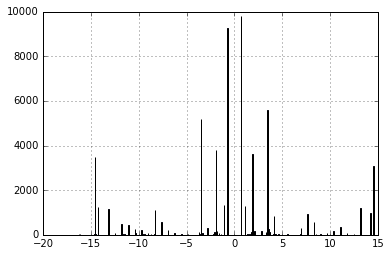

In [182]:
mask = ~train_df['targets_diff'].isin([0.0, -99999])
train_df[mask]['targets_diff'].apply(lambda x: np.sign(x)*np.log(np.abs(x) + 1)).hist(bins=500)

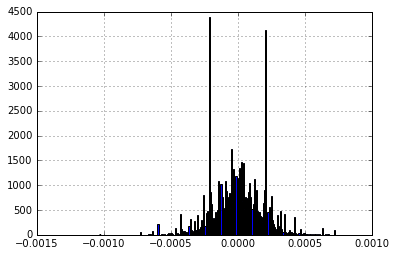

In [174]:
train_df[mask]['targets_logcount2_diff'].hist(bins=250)

In [201]:
mask = ~train_df['targets_diff'].isin([-99999])
train_fe_df = train_df.copy()
train_fe_df.loc[:,'age'] = train_df['age'].apply(get_age_group_index)
train_fe_df.loc[:,'renta'] = train_df['renta'].apply(get_income_group_index)
train_fe_df.loc[mask,'targets_logdiff'] = train_df[mask]['targets_diff'].apply(lambda x: np.sign(x)*np.log(np.abs(x) + 1))
train_fe_df.loc[~mask,'targets_logdiff'] = -99999

In [241]:
mask = ~val_df['targets_diff'].isin([-99999])
val_fe_df = val_df.copy()
val_fe_df.loc[:,'age'] = val_df['age'].apply(get_age_group_index)
val_fe_df.loc[:,'renta'] = val_df['renta'].apply(get_income_group_index)
val_fe_df.loc[mask,'targets_logdiff'] = val_df[mask]['targets_diff'].apply(lambda x: np.sign(x)*np.log(np.abs(x) + 1))
val_fe_df.loc[~mask,'targets_logdiff'] = -99999

In [202]:
train_fe_df[mask][['age', 'renta', 'targets_diff', 'targets_logdiff', 'targets_logcount2_diff', 'targets_logcount2', 'targets_logcount1', 'targets_logDec']].head()

,age,renta,targets_diff,targets_logdiff,targets_logcount2_diff,targets_logcount2,targets_logcount1,targets_logDec
1048503,11,4,0.0,0.0,0.0,0.000223,0.000310,13.23462
1466726,11,4,0.0,0.0,0.0,0.000223,0.000151,13.23462
2518926,11,4,0.0,0.0,0.0,0.000223,0.000247,13.23462
2940303,11,4,0.0,0.0,0.0,0.000223,0.000306,13.23462
4380305,11,4,0.0,0.0,0.0,0.000223,0.000244,13.23462


### Train a model

We can train over client features to predict products difference `diff`. 

``` python
for MM in ['04', '05']:
    X = [ Features | 'diff', abs('diff') ](2015-MM)
    Y = [ 'diff', abs('diff') ](2016-MM)
    CrossVal()
```

In [203]:
target_features = ['targets_diff', 'targets_logdiff', 'targets_logcount2_diff', 'targets_logcount2', 'targets_logcount1', 'targets_logDec']

In [204]:
active_clients_mask = ~train_df['targets_diff'].isin([0, -99999])

In [205]:
print active_clients_mask.shape, active_clients_mask.sum()

(1199928,) 61003


In [293]:
current_month = 201505
next_year_month = current_month + 100

df1 = train_fe_df if months_ym_map[current_month] in train_months else val_fe_df
df2 = train_fe_df if months_ym_map[next_year_month] in train_months else val_fe_df
#df2 = val_fe_df

month_mask = df1['fecha_dato'] == months_ym_map[current_month]
next_year_month_mask = df2['fecha_dato'] == months_ym_map[next_year_month]
        
common_clients_mask1, common_clients_mask2 = get_common_clients(df1, month_mask, next_year_month_mask, df2)

In [294]:
# print (month_mask & active_clients_mask).shape, (month_mask & active_clients_mask).sum()
# print (next_year_month_mask & active_clients_mask).shape, (next_year_month_mask & active_clients_mask).sum()

In [295]:
X = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + target_features + features]            
Y = df2[common_clients_mask2 & next_year_month_mask][['ncodpers', 'fecha_dato', 'targets_str'] + TARGET_LABELS]    
clients_last_choice = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + LC_TARGET_LABELS]
clients_last_choice.columns = ['ncodpers', 'fecha_dato'] + TARGET_LABELS
assert (X['ncodpers'].values == Y['ncodpers'].values).all(), "There is a problem in alignment"
Y.index = X.index

In [296]:
print X.shape
X.head(10)

(149875, 27)


,ncodpers,fecha_dato,targets_diff,targets_logdiff,targets_logcount2_diff,targets_logcount2,targets_logcount1,targets_logDec,ind_empleado,pais_residencia,...,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,ind_actividad_cliente,renta,segmento
2518926,15890,2015-05-28,0.0,0.000000,0.0,0.000223,0.000247,13.234620,1,0,...,0,0,0,1,1,0,0,1.0,4,0
2308266,15893,2015-05-28,0.0,0.000000,0.0,0.000589,0.001218,2.833213,0,0,...,0,0,0,1,1,0,0,1.0,11,0
2308272,15901,2015-05-28,0.0,0.000000,0.0,0.000211,0.000247,14.573060,4,0,...,0,0,0,1,1,0,0,1.0,9,1
2308275,15906,2015-05-28,-2.0,-1.098612,0.0,0.000046,0.000156,13.349075,0,0,...,0,0,0,1,1,0,0,1.0,5,1
2308278,15911,2015-05-28,0.0,0.000000,0.0,0.000058,0.000156,13.196866,4,0,...,0,0,0,1,1,0,0,1.0,10,1
2308263,15917,2015-05-28,0.0,0.000000,0.0,0.000680,0.001471,14.586863,4,0,...,0,0,0,1,1,0,11,1.0,-1,0
2308246,15919,2015-05-28,0.0,0.000000,0.0,0.000369,0.000650,14.588785,2,0,...,0,0,0,1,1,0,0,1.0,11,1
2308250,15923,2015-05-28,0.0,0.000000,0.0,0.000621,0.001300,13.173771,2,0,...,0,0,0,1,1,0,0,1.0,11,0
2308252,15925,2015-05-28,0.0,0.000000,0.0,0.000589,0.001255,14.586878,4,0,...,0,0,0,1,1,0,0,1.0,1,0
2308253,15926,2015-05-28,0.0,0.000000,0.0,0.000380,0.000684,14.587344,4,0,...,0,0,0,1,1,0,0,1.0,8,0


In [297]:
print Y.shape
Y.head(10)

(149875, 27)


,ncodpers,fecha_dato,targets_str,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
2518926,15890,2016-05-28,000010001000100100100111,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,1,1
2308266,15893,2016-05-28,000000000000000000010000,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2308272,15901,2016-05-28,001000001000110000110001,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
2308275,15906,2016-05-28,000010011001000000000011,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2308278,15911,2016-05-28,000010000001100000110001,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,0,1
2308263,15917,2016-05-28,001000010000000000000001,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2308246,15919,2016-05-28,001000000001000001000001,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2308250,15923,2016-05-28,000010000000100001100111,0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,1,1,1
2308252,15925,2016-05-28,001000010000000000100000,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2308253,15926,2016-05-28,001000010000010000010000,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [298]:
print clients_last_choice.shape
clients_last_choice.head(10)

(149875, 26)


,ncodpers,fecha_dato,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
2518926,15890,2015-05-28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2308266,15893,2015-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2308272,15901,2015-05-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2308275,15906,2015-05-28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
2308278,15911,2015-05-28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2308263,15917,2015-05-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2308246,15919,2015-05-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2308250,15923,2015-05-28,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0
2308252,15925,2015-05-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2308253,15926,2015-05-28,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Run KFold Cross-validation 

In [299]:
# def create_model(input_dim):
#     model = Sequential()
#     model.add(Dense(input_dim, init='uniform', input_dim=input_dim, activation='relu'))
#     model.add(Dropout(0.10))
#     model.add(Dense(50, activation='relu', init='normal'))
#     model.add(Dropout(0.10))
#     model.add(Dense(30, activation='relu', init='normal'))
#     model.add(Dropout(0.10))
#     model.add(Dense(1, init='normal'))
#     # for a mean squared error regression problem
#     model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])
#     return model

def create_model(profiles):
    ll = len(TARGET_LABELS)
    final_model = Sequential()
    models = []
    for key in profiles:
        length = len(profiles[key])
        model = Sequential()
        model.add(Dense(50, init='uniform', input_shape=(length,), activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(10 + length, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(ll, activation='sigmoid'))
        models.append(model)

    merged = Merge(models, mode='ave')
    final_model.add(merged)
    final_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return final_model

In [300]:
profiles = {
    0: ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],
    1: target_features,
    2: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
    3: ['pais_residencia', 'sexo', 'age', 'renta', 'targets_logdiff', 'targets_logcount2_diff','targets_logcount2','targets_logcount1'],
    11: ['nomprov', 'ind_nuevo', 'renta', 'ind_actividad_cliente', 'canal_entrada']
}


In [301]:
# CROSS VALIDATION
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
n_highest = 7


def prepare_to_fit(X_train, Y_train, profiles):
    # Select only active client for the training part
    mask = ~X_train['targets_diff'].isin([0, -99999])
    X_train_ = X_train[mask]
    y_train = Y_train[mask][TARGET_LABELS].values
    x_train = []
    for key in profiles:
        x_train_ = X_train_[profiles[key]].values
        #x_train_ = StandardScaler().fit_transform(x_train_)
        x_train.append(x_train_)
    return x_train, y_train


def prepare_to_test(X_val, profiles, Y_val=None):
    if Y_val is not None:
        y_val = Y_val[TARGET_LABELS].values
    
    x_val = []
    for key in profiles:
        x_val_ = X_val[profiles[key]].values    
        #x_val_ = StandardScaler().fit_transform(x_val_)  
        x_val.append(x_val_)    
    
    if Y_val is not None:
        return x_val, y_val
    else:
        return x_val

    
def pred_to_targets(y_pred, n_highest=7):
    predicted_added_products = np.argsort(y_pred, axis=1)
    predicted_added_products = predicted_added_products[:,::-1][:,:n_highest]
    return predicted_added_products
    

def cross_val_score2(data, 
                     profiles,
                     nb_folds=5, 
                     prepare_to_fit_func=prepare_to_fit, 
                     prepare_to_test_func=prepare_to_test,
                     transform_pred_func=pred_to_targets,
                     create_model_func=create_model):
    
    x_df, y_df, clients_last_choice_df = data
    kf = KFold(n_splits=nb_folds)
    scores = []
    
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_train, X_val = x_df.loc[x_df.index[train_index], :], x_df.loc[x_df.index[test_index], :]
        Y_train, Y_val = y_df.loc[y_df.index[train_index], :], y_df.loc[y_df.index[test_index], :]
        CLC_val = clients_last_choice_df.loc[clients_last_choice_df.index[test_index], :]
                
        x_train, y_train = prepare_to_fit_func(X_train, Y_train, profiles)
        x_val, y_val = prepare_to_test_func(X_val, profiles, Y_val)
        
        logging.info("- Train/Val shapes : {}, {} | {}, {}".format(
                [i.shape for i in x_train] if isinstance(x_train, list) else x_train.shape, 
                [i.shape for i in x_val] if isinstance(x_val, list) else x_val.shape, 
                y_train.shape, 
                y_val.shape)
        )                
            
        logging.info("- Create the model : ")
        estimator = create_model_func(profiles)
        logging.info("- Fit the model")
        hist = estimator.fit(x_train, y_train, nb_epoch=250, batch_size=5000, verbose=0)        
        for key in hist.history:            
            logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
        
        logging.info("- Predict using trained model")
        y_pred = estimator.predict(x_val, verbose=0)    
        y_pred = transform_pred_func(y_pred)
        logging.info("- Compute map7 score")
        scores.append(map7_score2(y_val, y_pred, CLC_val[TARGET_LABELS].values))        
    
    return np.array(scores)

In [302]:
nb_folds = 3
results = cross_val_score2((X, Y, clients_last_choice), 
                            profiles=profiles,
                            nb_folds=nb_folds)
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

INFO:root:- Train/Val shapes : [(5470, 8), (5470, 6), (5470, 5), (5470, 8), (5470, 5)], [(49959, 8), (49959, 6), (49959, 5), (49959, 8), (49959, 5)] | (5470, 24), (49959, 24)
INFO:root:- Create the model : 
INFO:root:- Fit the model
INFO:root:-- acc : min=0.544317, max=0.889321
INFO:root:-- loss : min=0.240433, max=0.687929
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.062641468385
INFO:root:- Train/Val shapes : [(7313, 8), (7313, 6), (7313, 5), (7313, 8), (7313, 5)], [(49958, 8), (49958, 6), (49958, 5), (49958, 8), (49958, 5)] | (7313, 24), (49958, 24)
INFO:root:- Create the model : 
INFO:root:- Fit the model
INFO:root:-- acc : min=0.552521, max=0.865838
INFO:root:-- loss : min=0.283247, max=0.688595
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0508657224449
INFO:root:- Train/Val shapes : [(7505, 8), (7505, 6), (7505, 5), (7505, 8), (7505, 5)], [(49958, 8), (499

Cross-Validation 
 3 | 0.050866 | 0.060776 | 0.068821 | 0.00745 


Compute cross-validation across several months

In [361]:
nb_folds = 3
#yms = [201503, 201504, 201505]
yms = [201505]

for ym in yms:
    logging.info("- Process month : %s" % ym)
    ym1 = ym + 100    
    df1 = train_fe_df if months_ym_map[ym] in train_months else val_fe_df
    df2 = train_fe_df if months_ym_map[ym1] in train_months else val_fe_df

    month_mask = df1['fecha_dato'] == months_ym_map[ym]
    next_year_month_mask = df2['fecha_dato'] == months_ym_map[ym1]
        
    common_clients_mask1, common_clients_mask2 = get_common_clients(df1, month_mask, next_year_month_mask, df2)
    
    X = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + target_features + features]            
    Y = df2[common_clients_mask2 & next_year_month_mask][['ncodpers', 'fecha_dato', 'targets_str'] + TARGET_LABELS]    
    clients_last_choice = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + LC_TARGET_LABELS]
    clients_last_choice.columns = ['ncodpers', 'fecha_dato'] + TARGET_LABELS

    assert (X['ncodpers'].values == Y['ncodpers'].values).all(), "There is a problem in alignment"
    Y.index = X.index

    results = cross_val_score2((X, Y, clients_last_choice), 
                                profiles=profiles,
                                nb_folds=nb_folds)
    print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

INFO:root:- Process month : 201505
INFO:root:- Train/Val shapes : [(5470, 8), (5470, 6), (5470, 5), (5470, 8), (5470, 5)], [(49959, 8), (49959, 6), (49959, 5), (49959, 8), (49959, 5)] | (5470, 24), (49959, 24)
INFO:root:- Create the model : 
INFO:root:- Fit the model
INFO:root:-- acc : min=0.490097, max=0.890532
INFO:root:-- loss : min=0.236189, max=0.710621
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0601623156385
INFO:root:- Train/Val shapes : [(7313, 8), (7313, 6), (7313, 5), (7313, 8), (7313, 5)], [(49958, 8), (49958, 6), (49958, 5), (49958, 8), (49958, 5)] | (7313, 24), (49958, 24)
INFO:root:- Create the model : 
INFO:root:- Fit the model
INFO:root:-- acc : min=0.533753, max=0.862676
INFO:root:-- loss : min=0.284812, max=0.695510
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0510950976598
INFO:root:- Train/Val shapes : [(7505, 8), (7505, 6), (7505, 5), (750

Cross-Validation 
 3 | 0.051095 | 0.059726 | 0.067921 | 0.00688 


### Test 1 : Train on active clients + feature engineering

#### Data: 

- train_yearmonths_list = [201503, 201504, 201505, 201506, 201603, 201604]
- val_yearmonth = [201605]
- train_nb_clients = 150000

#### Feature engineering

- age -> age group
- income -> income group
- targets logcount1, logcount2, logcount2_diff 
- target logDec, diff

#### Model

- 75 -> 50 -> 30 ->
- sigmoid, binary_crossentropy, nadam, accuracy, 

**Conf:**
- batch_size=5000

*Cross-validation results :* 

 Year-Month | Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
--- | --- | --- | --- | --- | --- | ---
201503 | 250 | 3 | 0.051612 | 0.064816 | 0.078062 | 0.01080 
201504 | 250 | 3 | 0.052616 | 0.063971 | 0.072449 | 0.00835 
201505 | 250 | 3 | 0.051095 | 0.059726 | 0.067921 | 0.00688 

Kaggle : 0.020662

#### Model 1 

- 50 -> 30 ->
- sigmoid, binary_crossentropy, nadam, accuracy, 

**Conf:**
- batch_size=2000

*Cross-validation results :* 

 Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
 --- | --- | --- | --- | --- | ---
 150 | 3 | 0.025802 | 0.030137 | 0.037217 | 0.00505 


Kaggle : 0.0197579

## Train model for predictions

In [372]:
current_month = 201505
next_year_month = current_month + 100

df1 = train_fe_df if months_ym_map[current_month] in train_months else val_fe_df
df2 = train_fe_df if months_ym_map[next_year_month] in train_months else val_fe_df

month_mask = df1['fecha_dato'] == months_ym_map[current_month]
next_year_month_mask = df2['fecha_dato'] == months_ym_map[next_year_month]
        
common_clients_mask1, common_clients_mask2 = get_common_clients(df1, month_mask, next_year_month_mask, df2)

In [373]:
X = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + target_features + features]            
Y = df2[common_clients_mask2 & next_year_month_mask][['ncodpers', 'fecha_dato', 'targets_str'] + TARGET_LABELS]    
clients_last_choice = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + LC_TARGET_LABELS]
clients_last_choice.columns = ['ncodpers', 'fecha_dato'] + TARGET_LABELS
assert (X['ncodpers'].values == Y['ncodpers'].values).all(), "There is a problem in alignment"
assert (X['ncodpers'].values == clients_last_choice['ncodpers'].values).all(), "There is a problem in alignment"
Y.index = X.index

In [378]:
def train_model(X_train, Y_train, profiles):

    x_train, y_train = prepare_to_fit(X_train, Y_train, profiles)
    logging.info("- Train data shapes : {}, {}".format(
            [i.shape for i in x_train] if isinstance(x_train, list) else x_train.shape, 
            y_train.shape)
    )                

    logging.info("- Create the model")
    
    estimator = create_model(profiles)
    logging.info("- Fit the model")
    hist = estimator.fit(x_train, y_train, nb_epoch=250, batch_size=5000, verbose=0)        
    for key in hist.history:            
        logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
    return estimator

estimator = train_model(X, Y, profiles)

INFO:root:- Train data shapes : [(10144, 8), (10144, 6), (10144, 5), (10144, 8), (10144, 5)], (10144, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.606126, max=0.870129
INFO:root:-- loss : min=0.278354, max=0.679641


Check score on the data 2016/05

In [379]:
x_val, y_val = prepare_to_test(X, profiles, Y)

logging.info("- Predict using trained model")
y_pred = estimator.predict(x_val, verbose=0)    
y_pred = pred_to_targets(y_pred)
logging.info("- Compute map7 score")
print map7_score2(y_val, y_pred, clients_last_choice[TARGET_LABELS].values)

INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0617705903067


0.0617705903067


## Prediction for 2016/06

In [334]:
from common import minimal_clean_data_inplace, preprocess_data_inplace

In [335]:
test_df = load_data2(TEST_FILE_PATH, [])
minimal_clean_data_inplace(test_df)
preprocess_data_inplace(test_df)
test_df = test_df.sort_values(['ncodpers'])


INFO:root:-- Read all data from the file : ../data/test_ver2.csv
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10


In [339]:
print test_df.shape, 

(929615, 22)


In [383]:
train_df, val_df = load_trainval([201502], [201506], 100)

INFO:root:- Load training data : [201501, 201502]
INFO:root:-- Select 100 clients
INFO:root:- Number of lines with unknown data : 2
INFO:root:- Number of columns with nan : 5
INFO:root:-- Process date : 201502
INFO:root:- Load validation : [201505, 201506]
INFO:root:-- Select max clients
INFO:root:- Number of lines with unknown data : 3716
INFO:root:- Number of columns with nan : 10
INFO:root:-- Process date : 201506


In [338]:
current_month = 201506

month_mask = val_fe_df['fecha_dato'] == months_ym_map[current_month]
next_month_mask = test_df['fecha_dato'] == '2016-06-28'
        
common_clients_mask1, common_clients_mask2 = get_common_clients(val_fe_df, month_mask, next_month_mask, test_df)

In [342]:
print (common_clients_mask1 & month_mask).sum(), common_clients_mask2.sum()

925252 925252


In [343]:
X = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + target_features + features]            
clients_last_choice = df1[common_clients_mask1 & month_mask][['ncodpers', 'fecha_dato'] + TARGET_LABELS]

In [344]:
print X.shape

(925252, 27)


In [345]:
def get_submission(predicted_added_products, clients, clc, target_labels):
    added_products_col = []
    count = 0 
    for products, last_choice in zip(predicted_added_products, clc):
        predictions = remove_last_choice(products, last_choice)
        added_products_col.append(' '.join([target_labels[i] for i in predictions]))
        count+=1
        if count % 100000 == 0:
            logging.info("Elapsed : %i", count)
            
    out = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
    return out

In [371]:
(clients_last_choice['ncodpers'].values == X['ncodpers'].values).all()

True

In [346]:
x_val = prepare_to_test(X, profiles)
logging.info("- Predict using trained model")
y_pred = estimator.predict(x_val, verbose=0)    
y_pred = pred_to_targets(y_pred)
logging.info("- Get submission dataframe:")
clients = X['ncodpers'].values
submission = get_submission(y_pred, clients, clients_last_choice[TARGET_LABELS].values, TARGET_LABELS)

INFO:root:- Predict using trained model
INFO:root:- Get submission dataframe:
INFO:root:Elapsed : 100000
INFO:root:Elapsed : 200000
INFO:root:Elapsed : 300000
INFO:root:Elapsed : 400000
INFO:root:Elapsed : 500000
INFO:root:Elapsed : 600000
INFO:root:Elapsed : 700000
INFO:root:Elapsed : 800000
INFO:root:Elapsed : 900000


In [358]:
submission_clients = set(submission['ncodpers'].unique())
test_clients = set(test_df['ncodpers'].unique())
if submission_clients != test_clients:
    missing_clients = list(test_clients - submission_clients)
    missing_added_products = np.zeros((len(missing_clients)))
    submission = pd.concat([submission, 
                            pd.DataFrame(data={
                                'ncodpers': missing_clients, 
                                'added_products': missing_added_products
                            }, columns=['ncodpers', 'added_products'])])

Get submission DataFrame and write csv file

In [359]:
print submission.shape
submission.head()

(929615, 2)


,ncodpers,added_products
0,15889,ind_recibo_ult1 ind_ecue_fin_ult1 ind_cno_fin_...
1,15890,ind_cco_fin_ult1 ind_fond_fin_ult1 ind_reca_fi...
2,15892,ind_cno_fin_ult1 ind_nom_pens_ult1 ind_fond_fi...
3,15893,ind_recibo_ult1 ind_cco_fin_ult1 ind_nom_pens_...
4,15894,ind_cno_fin_ult1 ind_fond_fin_ult1


In [360]:
from datetime import datetime
import csv

logging.info('- Generate submission')
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'

submission.to_csv(submission_file, index=False, index_label=False)

INFO:root:- Generate submission


In [362]:
with open('../results/submission_2016-11-17-16-37.csv', 'r') as r:
    print r.readline()
    print r.readline()
    print r.readline()
    print r.readline()
    print r.readline()
    

ncodpers,added_products

15889,ind_ecue_fin_ult1 ind_recibo_ult1 ind_dela_fin_ult1 ind_cno_fin_ult1 ind_nom_pens_ult1 ind_ctop_fin_ult1 ind_nomina_ult1 

1170544,ind_recibo_ult1 ind_cno_fin_ult1 ind_ecue_fin_ult1 ind_ctop_fin_ult1 ind_nom_pens_ult1 ind_reca_fin_ult1 ind_ctpp_fin_ult1 

1170545,ind_recibo_ult1 ind_cno_fin_ult1 ind_ecue_fin_ult1 ind_nom_pens_ult1 ind_nomina_ult1 ind_reca_fin_ult1 ind_dela_fin_ult1 

1170547,ind_recibo_ult1 ind_cno_fin_ult1 ind_ecue_fin_ult1 ind_nom_pens_ult1 ind_nomina_ult1 ind_reca_fin_ult1 ind_dela_fin_ult1 

